In [ ]:
!pip install scikit-fuzzy scikit-image --quiet

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from skimage.metrics import hausdorff_distance

In [17]:
base = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"

print("Inside root folder:")
print(os.listdir(base))

Inside root folder:
['Ground Truth', 'Original']


In [18]:
BASE_PATH = "/kaggle/input/raabindata-nucleus-cytoplasm-ground-truths/GrTh"

ORIGINAL = os.path.join(BASE_PATH, "Original")
GROUNDTRUTH = os.path.join(BASE_PATH, "Ground Truth")

In [19]:
ORIGINAL = os.path.join(BASE_PATH, "Original")
GROUNDTRUTH = os.path.join(BASE_PATH, "Ground Truth")

cell_types = ["Eosinophil","Lymphocyte","Monocyte","Neutrophil"]

In [20]:
files = []
for cell in cell_types:
    img_paths = glob(os.path.join(ORIGINAL, cell, "*.*"))
    for p in img_paths:
        if p.lower().endswith(('.png','.jpg','.jpeg','.bmp')):
            files.append((cell, p))

print("Total images:", len(files))


Total images: 927


In [21]:
def load_pair(file_tuple):
    cell, img_path = file_tuple
    mask_path = img_path.replace("Original", "Ground Truth")

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, 0)

    return img, mask

In [22]:
def split_gt(mask):
    nucleus = (mask > 200).astype(np.uint8)
    cytoplasm = ((mask > 30) & (mask <= 200)).astype(np.uint8)
    return nucleus, cytoplasm

In [23]:
def crop_to_cell(img, n_gt, c_gt, resize_to=224):

    wbc = (n_gt + c_gt).astype(np.uint8)

    coords = np.column_stack(np.where(wbc > 0))
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)

    img_crop = img[y0:y1, x0:x1]
    n_crop = n_gt[y0:y1, x0:x1]
    c_crop = c_gt[y0:y1, x0:x1]

    img_crop = cv2.resize(img_crop, (resize_to, resize_to))
    n_crop = cv2.resize(n_crop, (resize_to, resize_to), interpolation=cv2.INTER_NEAREST)
    c_crop = cv2.resize(c_crop, (resize_to, resize_to), interpolation=cv2.INTER_NEAREST)

    return img_crop, n_crop, c_crop

In [24]:
def kmeans_seg(img, k):

    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    X = img_lab.reshape((-1,3)).astype(np.float32)

    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X)

    return labels.reshape(img.shape[:2])

In [25]:
def fcm_seg(img, k):

    img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    X = img_lab.reshape((-1,3)).T.astype(np.float32)

    centers, membership, _,_,_,_,_ = fuzz.cluster.cmeans(
        X, k, m=2, error=0.005, maxiter=1000
    )

    return membership

In [26]:
def map_clusters(pred, gt_n, gt_c):

    cluster_ids = np.unique(pred)

    nuc_score=[]
    cyt_score=[]

    for c in cluster_ids:
        mask = pred==c
        nuc_score.append(np.sum(mask & gt_n))
        cyt_score.append(np.sum(mask & gt_c))

    n_id = cluster_ids[np.argmax(nuc_score)]
    c_id = cluster_ids[np.argmax(cyt_score)]

    return n_id, c_id

In [27]:
def boundary_f1(pred, gt):

    kernel = np.ones((3,3),np.uint8)

    pred_b = cv2.morphologyEx(pred, cv2.MORPH_GRADIENT, kernel)
    gt_b = cv2.morphologyEx(gt, cv2.MORPH_GRADIENT, kernel)

    tp = np.sum((pred_b==1)&(gt_b==1))
    fp = np.sum((pred_b==1)&(gt_b==0))
    fn = np.sum((pred_b==0)&(gt_b==1))

    precision = tp/(tp+fp+1e-8)
    recall = tp/(tp+fn+1e-8)

    return 2*precision*recall/(precision+recall+1e-8)

def hausdorff(gt, pred):
    if np.sum(gt)==0 or np.sum(pred)==0:
        return np.nan
    return hausdorff_distance(gt, pred)

In [28]:
k_values = [2,3]
thresholds = [0.4,0.5,0.6]

results=[]

for k in k_values:

    print(f"\nTesting k = {k}")

    for file in files:

        img, gt = load_pair(file)
        gt_n, gt_c = split_gt(gt)
        img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

        # -------- KMEANS --------
        km_labels = kmeans_seg(img, k)
        n_id, c_id = map_clusters(km_labels, gt_n, gt_c)
        km_n = (km_labels==n_id).astype(np.uint8)

        km_f1 = boundary_f1(km_n, gt_n)
        km_hd = hausdorff(gt_n, km_n)

        # -------- FCM --------
        membership = fcm_seg(img, k)
        hard = np.argmax(membership, axis=0).reshape(img.shape[:2])
        n_id, c_id = map_clusters(hard, gt_n, gt_c)

        nucleus_prob = membership[n_id].reshape(img.shape[:2])

        for t in thresholds:

            fcm_n = (nucleus_prob > t).astype(np.uint8)
            fcm_f1 = boundary_f1(fcm_n, gt_n)
            fcm_hd = hausdorff(gt_n, fcm_n)

            results.append([k,t,km_f1,km_hd,fcm_f1,fcm_hd])


Testing k = 2

Testing k = 3


In [29]:
df = pd.DataFrame(results, columns=[
    "k","threshold",
    "KM_BoundaryF1","KM_Hausdorff",
    "FCM_BoundaryF1","FCM_Hausdorff"
])

summary = df.groupby(["k","threshold"]).mean()

print("\n===== FINAL SUMMARY =====")
print(summary)

best = summary["FCM_BoundaryF1"].idxmax()
print("\nBest FCM Boundary Accuracy → k =", best[0], " threshold =", best[1])

best_hd = summary["FCM_Hausdorff"].idxmin()
print("Lowest FCM Hausdorff → k =", best_hd[0], " threshold =", best_hd[1])


===== FINAL SUMMARY =====
             KM_BoundaryF1  KM_Hausdorff  FCM_BoundaryF1  FCM_Hausdorff
k threshold                                                            
2 0.4             0.144574     56.301909        0.157127      56.730329
  0.5             0.144574     56.301909        0.140227      56.404376
  0.6             0.144574     56.301909        0.128332      56.133540
3 0.4             0.196974     51.569208        0.215870      51.635804
  0.5             0.196974     51.569208        0.194994      51.250980
  0.6             0.196974     51.569208        0.173515      50.809050

Best FCM Boundary Accuracy → k = 3  threshold = 0.4
Lowest FCM Hausdorff → k = 3  threshold = 0.6


In [30]:
def visualize_results(file_tuple, k=3, threshold=0.5):

    img, gt = load_pair(file_tuple)
    gt_n, gt_c = split_gt(gt)
    img, gt_n, gt_c = crop_to_cell(img, gt_n, gt_c)

    # -------- KMEANS --------
    km_labels = kmeans_seg(img, k)
    n_id, c_id = map_clusters(km_labels, gt_n, gt_c)
    km_n = (km_labels == n_id).astype(np.uint8)

    # -------- FCM --------
    membership = fcm_seg(img, k)
    hard = np.argmax(membership, axis=0).reshape(img.shape[:2])
    n_id, c_id = map_clusters(hard, gt_n, gt_c)

    nucleus_prob = membership[n_id].reshape(img.shape[:2])
    fcm_n = (nucleus_prob > threshold).astype(np.uint8)

    # -------- OVERLAY FUNCTION --------
    def overlay_boundary(image, mask, color):
        overlay_img = image.copy()
        contours, _ = cv2.findContours(mask.astype(np.uint8),
                                       cv2.RETR_EXTERNAL,
                                       cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay_img, contours, -1, color, 2)
        return overlay_img

    km_overlay = overlay_boundary(img, km_n, (0,255,0))      # Green
    fcm_overlay = overlay_boundary(img, fcm_n, (255,0,0))    # Red

    # -------- PLOTTING --------
    plt.figure(figsize=(18,8))

    plt.subplot(2,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(2,3,2)
    plt.imshow(gt_n, cmap='gray')
    plt.title("Ground Truth (Nucleus)")
    plt.axis('off')

    plt.subplot(2,3,3)
    plt.imshow(km_n, cmap='gray')
    plt.title("K-Means (Nucleus)")
    plt.axis('off')

    plt.subplot(2,3,4)
    plt.imshow(fcm_n, cmap='gray')
    plt.title(f"FCM (Threshold={threshold})")
    plt.axis('off')

    plt.subplot(2,3,5)
    plt.imshow(nucleus_prob, cmap='hot')
    plt.title("FCM Soft Membership Map")
    plt.axis('off')

    plt.subplot(2,3,6)
    combined = cv2.addWeighted(km_overlay, 0.5, fcm_overlay, 0.5, 0)
    plt.imshow(combined)
    plt.title("Boundary Overlay (Green=KM, Red=FCM)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

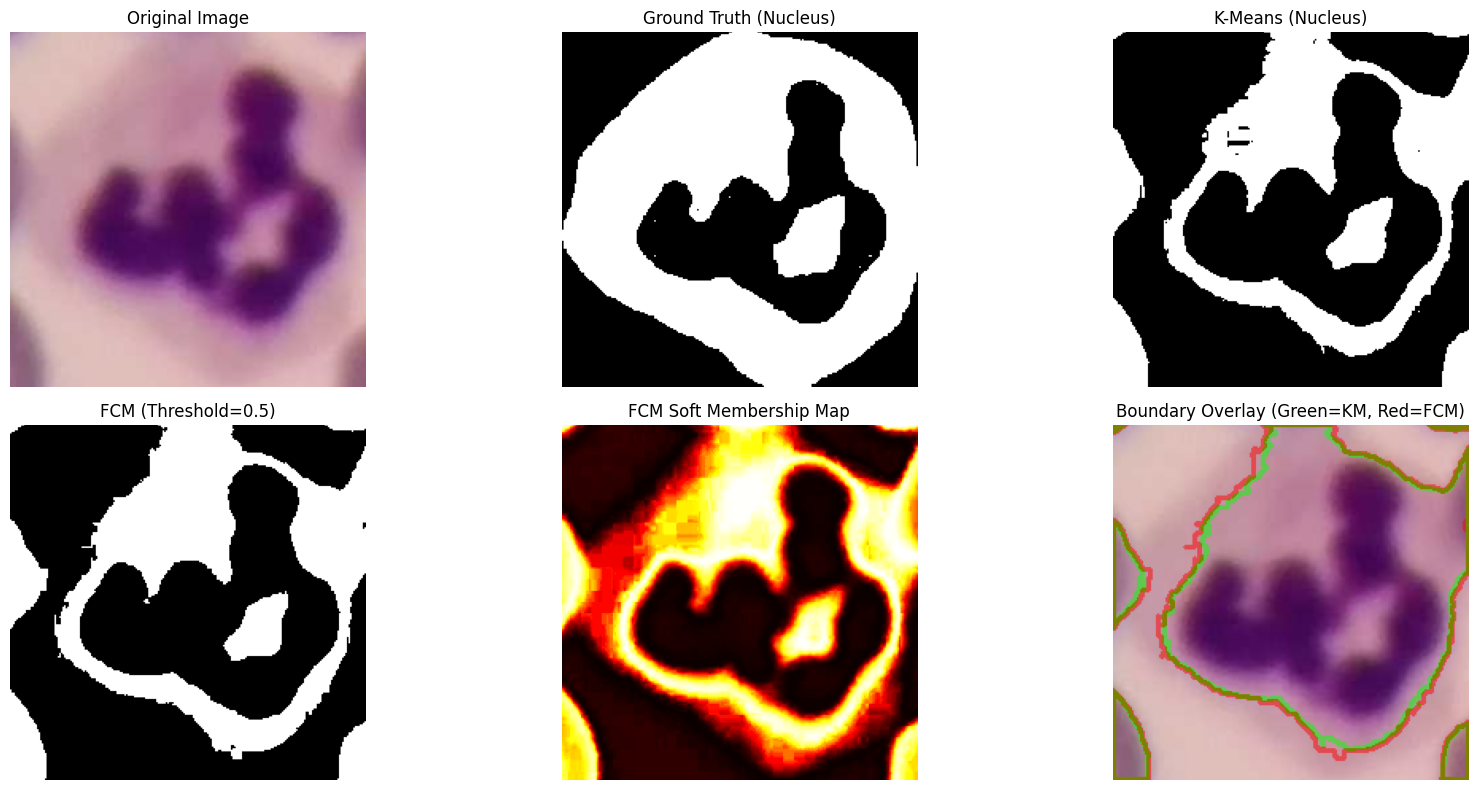

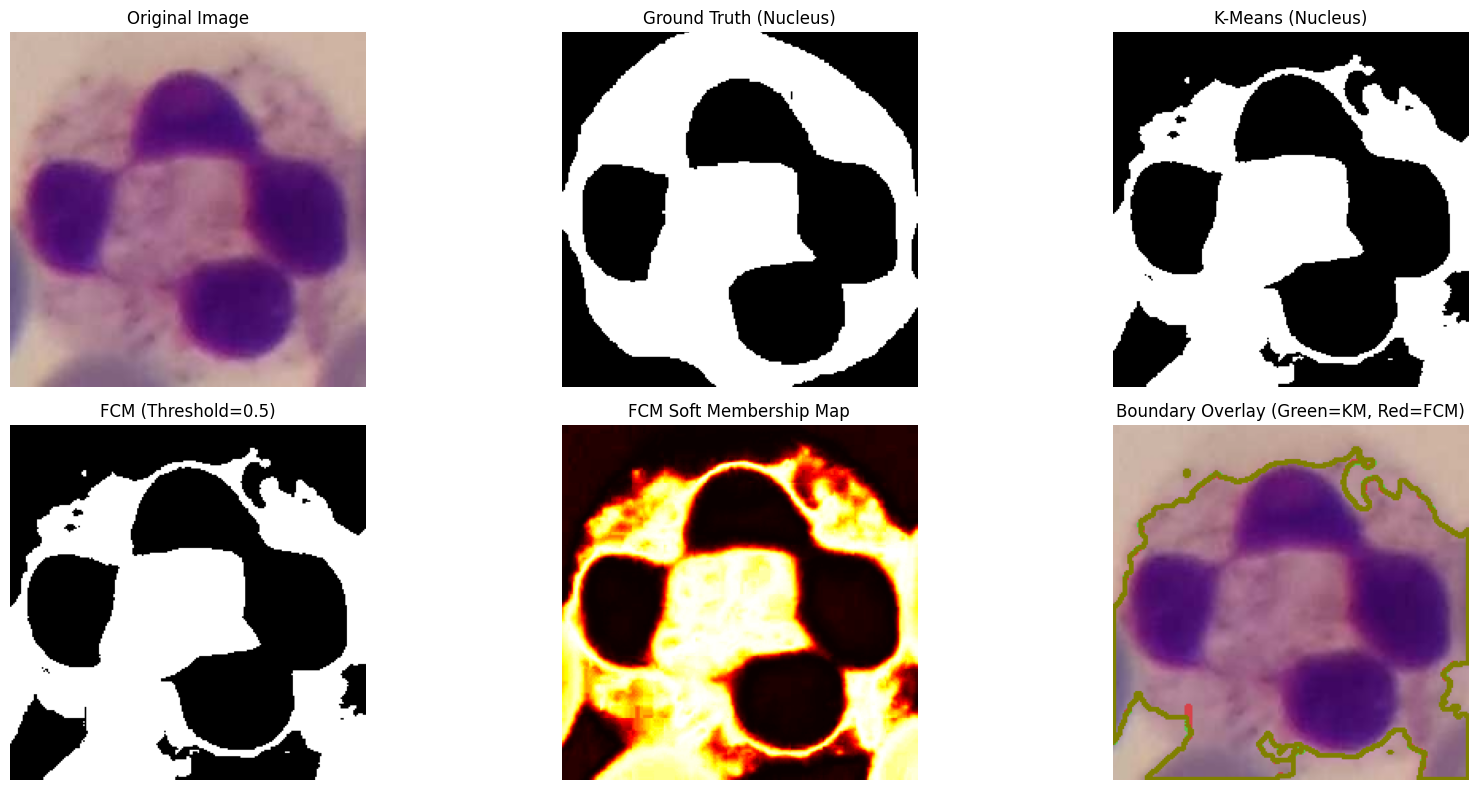

In [34]:
for f in files[-2:]:
    visualize_results(f, k=3, threshold=0.5)